<a href="https://colab.research.google.com/github/anushavasup/OCR-Handwriting-Prediction/blob/main/OCR_handwriting_mod.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/content/drive')



Mounted at /content/drive


In [49]:
# set the matplotlib backend so figures can be saved in the background
import matplotlib

# import the necessary
from tensorflow.keras.datasets import mnist
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers.legacy import SGD
from sklearn.preprocessing import LabelBinarizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from tensorflow.keras.models import load_model
from imutils.contours import sort_contours
from imutils import build_montages
import matplotlib.pyplot as plt
import numpy as np
import cv2
from google.colab.patches import cv2_imshow


## Load the A-Z and MNIST datasets

In [50]:
#Load the Kaggle A-Z letters.
def load_az_dataset(dataset_path):
    # initialize the list of data and labels
    data = []
    labels = []

    # loop over the rows of the A-Z handwritten digit dataset
    for row in open(dataset_path):

        # parse the label and image from the row
        row = row.split(",")

        label = int(row[0])

        image = np.array([int(x) for x in row[1:]], dtype="uint8")

        # images are represented as single channel (grayscale) images
        # that are 28x28=784 pixels -- we need to take this flattened
        # 784-d list of numbers and reshape them into a 28x28 matrix
        image = image.reshape((28, 28))

        # update the list of data and labels
        data.append(image)
        labels.append(label)


    # convert the data and labels to NumPy arrays
    data = np.array(data, dtype="float32")
    labels = np.array(labels, dtype="int")



    # return a 2-tuple of the A-Z data and labels
    return (data, labels)

In [51]:
#Load the MNIST 0–9 digits.
def load_zero_nine_dataset():
    # load the MNIST dataset and stack the training data and testing
    # data together (we'll create our own training and testing splits
    # later in the project)
    ((trainData, trainLabels), (testData, testLabels)) = mnist.load_data()
    data = np.vstack([trainData, testData])
    labels = np.hstack([trainLabels, testLabels])
    # return a 2-tuple of the MNIST data and labels

    return (data, labels)

In [52]:
#Combine them into one.
# load all datasets
(azData, azLabels) = load_az_dataset('/content/drive/MyDrive/ocr/a_z_handwritten_data.csv')
(digitsData, digitsLabels) = load_zero_nine_dataset()

11490434/11490434 [==============================] - 0s 0us/step


In [53]:
azLabels

array([ 0,  0,  0, ..., 25, 25, 25])

## Preparing the data and the labels

In [54]:
# the MNIST dataset occupies the labels 0-9, so let's add 10 to every
# A-Z label to ensure the A-Z characters are not incorrectly labeled
# as digits
azLabels += 10

# stack the A-Z data and labels with the MNIST digits data and labels
data = np.vstack([azData, digitsData])
labels = np.hstack([azLabels, digitsLabels])

# each image in the A-Z and MNIST digts datasets are 28x28 pixels;
# however, the architecture we're using is designed for 32x32 images,
# so we need to resize them to 32x32
data = [cv2.resize(image, (32, 32)) for image in data]
data = np.array(data, dtype="float32")

# add a channel dimension to every image in the dataset and scale the
# pixel intensities of the images from [0, 255] down to [0, 1]
data = np.expand_dims(data, axis=-1)
data /= 255.0

# convert the labels from integers to vectors
le = LabelBinarizer()
labels = le.fit_transform(labels)
counts = labels.sum(axis=0)

# account for skew in the labeled data
classTotals = labels.sum(axis=0)
classWeight = {}


# loop over all classes and calculate the class weight
for i in range(0, len(classTotals)):
	classWeight[i] = classTotals.max() / classTotals[i]



## Split the data into train and test

In [55]:

# partition the data into training and testing splits using 80% of
# the data for training and the remaining 20% for testing
(trainX, testX, trainY, testY) = train_test_split(data,
	labels, test_size=0.20,random_state=42)

## Data augmentation

In [56]:

# construct the image generator for data augmentation
aug = ImageDataGenerator(
	rotation_range=10,
	zoom_range=0.05,
	width_shift_range=0.1,
	height_shift_range=0.1,
	shear_range=0.15,
	horizontal_flip=False,
	fill_mode="nearest")


In [57]:
# import the necessary packages

from keras.layers import BatchNormalization
from keras.layers import Conv2D
from keras.layers import AveragePooling2D
from keras.layers import MaxPooling2D
from keras.layers import ZeroPadding2D
from keras.layers import Activation
from keras.layers import Dense
from keras.layers import Flatten
from keras.layers import Input
from keras.models import Model
from keras.layers import add
from keras.regularizers import l2
from keras import backend as K


class ResNet:
    @staticmethod
    def residual_module(data, K, stride, chanDim, red=False,
                        reg=0.0001, bnEps=2e-5, bnMom=0.9):
        # the shortcut branch of the ResNet module should be
        # initialize as the input (identity) data
        shortcut = data

        # the first block of the ResNet module are the 1x1 CONVs
        bn1 = BatchNormalization(axis=chanDim, epsilon=bnEps,
                                 momentum=bnMom)(data)
        act1 = Activation("relu")(bn1)
        conv1 = Conv2D(int(K * 0.25), (1, 1), use_bias=False,
                       kernel_regularizer=l2(reg))(act1)

        # the second block of the ResNet module are the 3x3 CONVs
        bn2 = BatchNormalization(axis=chanDim, epsilon=bnEps,
                                 momentum=bnMom)(conv1)
        act2 = Activation("relu")(bn2)
        conv2 = Conv2D(int(K * 0.25), (3, 3), strides=stride,
                       padding="same", use_bias=False,
                       kernel_regularizer=l2(reg))(act2)

        # the third block of the ResNet module is another set of 1x1
        # CONVs
        bn3 = BatchNormalization(axis=chanDim, epsilon=bnEps,
                                 momentum=bnMom)(conv2)
        act3 = Activation("relu")(bn3)
        conv3 = Conv2D(K, (1, 1), use_bias=False,
                       kernel_regularizer=l2(reg))(act3)

        # if we are to reduce the spatial size, apply a CONV layer to
        # the shortcut
        if red:
            shortcut = Conv2D(K, (1, 1), strides=stride,
                              use_bias=False, kernel_regularizer=l2(reg))(act1)

        # add together the shortcut and the final CONV
        x = add([conv3, shortcut])

        # return the addition as the output of the ResNet module
        return x

    @staticmethod
    def build(width, height, depth, classes, stages, filters,
              reg=0.0001, bnEps=2e-5, bnMom=0.9, dataset="cifar"):
        # initialize the input shape to be "channels last" and the
        # channels dimension itself
        inputShape = (height, width, depth)
        chanDim = -1

        # if we are using "channels first", update the input shape
        # and channels dimension
        if K.image_data_format() == "channels_first":
            inputShape = (depth, height, width)
            chanDim = 1

        # set the input and apply BN
        inputs = Input(shape=inputShape)
        x = BatchNormalization(axis=chanDim, epsilon=bnEps,
                               momentum=bnMom)(inputs)

        # check if we are utilizing the CIFAR dataset
        if dataset == "cifar":
            # apply a single CONV layer
            x = Conv2D(filters[0], (3, 3), use_bias=False,
                       padding="same", kernel_regularizer=l2(reg))(x)

        # check to see if we are using the Tiny ImageNet dataset
        elif dataset == "tiny_imagenet":
            # apply CONV => BN => ACT => POOL to reduce spatial size
            x = Conv2D(filters[0], (5, 5), use_bias=False,
                       padding="same", kernel_regularizer=l2(reg))(x)
            x = BatchNormalization(axis=chanDim, epsilon=bnEps,
                                   momentum=bnMom)(x)
            x = Activation("relu")(x)
            x = ZeroPadding2D((1, 1))(x)
            x = MaxPooling2D((3, 3), strides=(2, 2))(x)

        # loop over the number of stages
        for i in range(0, len(stages)):
            # initialize the stride, then apply a residual module
            # used to reduce the spatial size of the input volume
            stride = (1, 1) if i == 0 else (2, 2)
            x = ResNet.residual_module(x, filters[i + 1], stride,
                                       chanDim, red=True, bnEps=bnEps, bnMom=bnMom)

            # loop over the number of layers in the stage
            for j in range(0, stages[i] - 1):
                # apply a ResNet module
                x = ResNet.residual_module(x, filters[i + 1],
                                           (1, 1), chanDim, bnEps=bnEps, bnMom=bnMom)

        # apply BN => ACT => POOL
        x = BatchNormalization(axis=chanDim, epsilon=bnEps,
                               momentum=bnMom)(x)
        x = Activation("relu")(x)
        x = AveragePooling2D((8, 8))(x)

        # softmax classifier
        x = Flatten()(x)
        x = Dense(classes, kernel_regularizer=l2(reg))(x)
        x = Activation("softmax")(x)

        # create the model
        model = Model(inputs, x, name="resnet")

        # return the constructed network architecture
        return model

## Build and train the model

In [58]:
# initialize the number of epochs to train for, initial learning rate,
# and batch size
EPOCHS = 15 #50
INIT_LR = 1e-1
BS = 128

# initialize and compile our deep neural network
print("[INFO] compiling model...")
opt = SGD(learning_rate=INIT_LR, decay=INIT_LR / EPOCHS)
model = ResNet.build(32, 32, 1, len(le.classes_), (3, 3, 3),
	(64, 64, 128, 256), reg=0.0005)
model.compile(loss="categorical_crossentropy", optimizer=opt,
	metrics=["accuracy"])

[INFO] compiling model...


In [ ]:

# train the network
print("[INFO] training network...")
H = model.fit(
	aug.flow(trainX, trainY, batch_size=BS),
	validation_data=(testX, testY),
	steps_per_epoch=len(trainX) // BS,
	epochs=EPOCHS,
	class_weight=classWeight,
	verbose=1)


[INFO] training network...
Epoch 1/15
2765/2765 [==============================] - 211s 72ms/step - loss: 2.0366 - accuracy: 0.8656 - val_loss: 0.5547 - val_accuracy: 0.8770
Epoch 2/15
2765/2765 [==============================] - 205s 74ms/step - loss: 1.0467 - accuracy: 0.9213 - val_loss: 0.5352 - val_accuracy: 0.8863
Epoch 3/15
2765/2765 [==============================] - 203s 73ms/step - loss: 0.9714 - accuracy: 0.9272 - val_loss: 0.5567 - val_accuracy: 0.8769
Epoch 4/15
2765/2765 [==============================] - 206s 74ms/step - loss: 0.9274 - accuracy: 0.9311 - val_loss: 0.5658 - val_accuracy: 0.8749
Epoch 5/15
2765/2765 [==============================] - 201s 73ms/step - loss: 0.9053 - accuracy: 0.9329 - val_loss: 0.5870 - val_accuracy: 0.8656
Epoch 6/15
2765/2765 [==============================] - 197s 71ms/step - loss: 0.8923 - accuracy: 0.9338 - val_loss: 0.5895 - val_accuracy: 0.8646
Epoch 7/15
2765/2765 [==============================] - 200s 72ms/step - loss: 0.8740 - acc

Load the handwriting OCR model


[INFO] evaluating network...
692/692 [==============================] - 10s 14ms/step
              precision    recall  f1-score   support

           0       0.16      0.97      0.27      1395
           1       0.98      0.98      0.98      1590
           2       0.87      0.96      0.92      1395
           3       0.95      0.99      0.97      1441
           4       0.85      0.98      0.91      1384
           5       0.41      0.97      0.57      1265
           6       0.94      0.99      0.96      1341
           7       0.95      0.98      0.96      1519
           8       0.86      0.99      0.92      1368
           9       0.96      0.98      0.97      1383
           A       0.99      0.99      0.99      2721
           B       0.97      0.98      0.98      1733
           C       0.99      0.96      0.98      4637
           D       0.94      0.96      0.95      2067
           E       0.98      0.99      0.98      2297
           F       0.97      0.99      0.98      

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


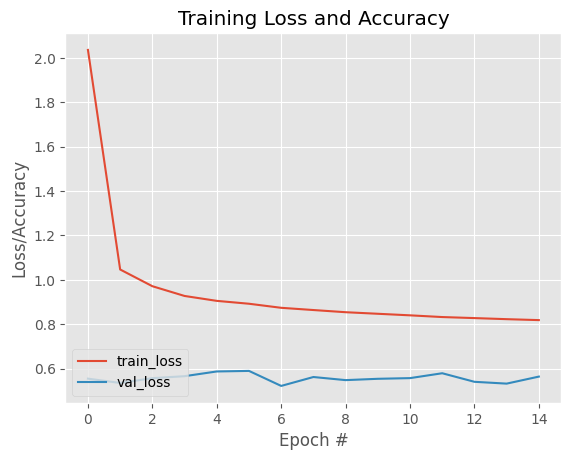

In [ ]:
# define the list of label names
labelNames = "0123456789"
labelNames += "ABCDEFGHIJKLMNOPQRSTUVWXYZ"
labelNames = [l for l in labelNames]

# evaluate the network
print("[INFO] evaluating network...")
predictions = model.predict(testX, batch_size=BS)
print(classification_report(testY.argmax(axis=1),
	predictions.argmax(axis=1), target_names=labelNames))

#save the model to disk
print("[INFO] serializing network...")
model.save("handwriting.model", save_format="h5")

# construct a plot that plots and saves the training history
N = np.arange(0, EPOCHS)
plt.style.use("ggplot")
plt.figure()
plt.plot(N, H.history["loss"], label="train_loss")
plt.plot(N, H.history["val_loss"], label="val_loss")
plt.title("Training Loss and Accuracy")
plt.xlabel("Epoch #")
plt.ylabel("Loss/Accuracy")
plt.legend(loc="lower left")
plt.savefig("plot")


## Classify characters

1/1 [==============================] - 0s 19ms/step


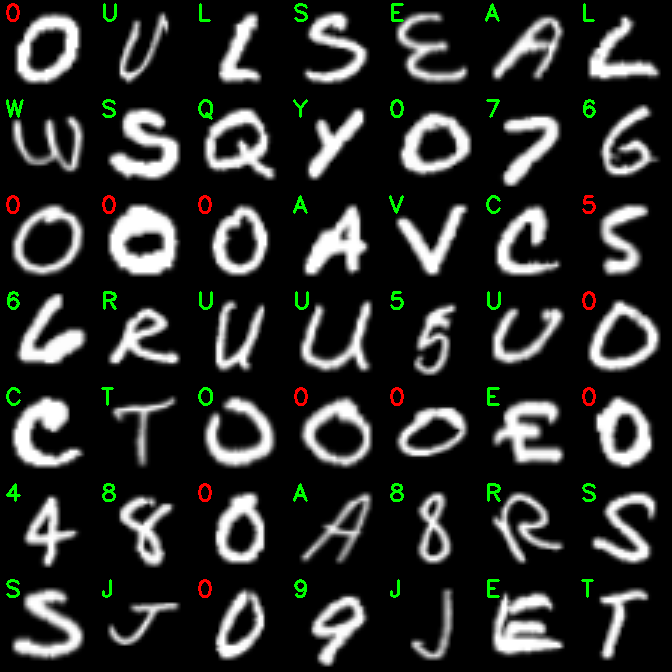

-1

In [ ]:

# initialize our list of output images
images = []

# randomly select a few testing characters
for i in np.random.choice(np.arange(0, len(testY)), size=(49,)):
	# classify the character

	probs = model.predict(testX[np.newaxis, i])
	prediction = probs.argmax(axis=1)
	label = labelNames[prediction[0]]

	# extract the image from the test data and initialize the text
	# label color as green (correct)
	image = (testX[i] * 255).astype("uint8")
	color = (0, 255, 0)

	# otherwise, the class label prediction is incorrect
	if prediction[0] != np.argmax(testY[i]):
		color = (0, 0, 255)

	# merge the channels into one image, resize the image from 32x32
	# to 96x96 so we can better see it and then draw the predicted
	# label on the image
	image = cv2.merge([image] * 3)
	image = cv2.resize(image, (96, 96), interpolation=cv2.INTER_LINEAR)
	cv2.putText(image, label, (5, 20), cv2.FONT_HERSHEY_SIMPLEX, 0.75,
		color, 2)

	# add the image to our list of output images
	images.append(image)

# construct the montage for the images
montage = build_montages(images, (96, 96), (7, 7))[0]

# show the output montage
cv2_imshow(montage)
cv2.waitKey(0)

In [2]:

# import the necessary packages
from tensorflow.keras.models import load_model
from imutils.contours import sort_contours
import numpy as np
import argparse
import imutils
import cv2
from google.colab.patches import cv2_imshow


## Load the handwriting OCR model

In [3]:
print("[INFO] loading handwriting OCR model...")
model = load_model('/content/drive/MyDrive/ocr/handwriting.model')

[INFO] loading handwriting OCR model...


## Image preprocessing

In [4]:
import cv2
import numpy as np



# get grayscale image
def get_grayscale(image):
    return cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

# noise removal
def remove_noise(image):
    return cv2.medianBlur(image,5)

#thresholding
def thresholding(image):
    return cv2.threshold(image, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)[1]

#adaptiveThresholding
def adadaptiveThresholding(image):
    return cv2.adaptiveThreshold(image,255,cv2.ADAPTIVE_THRESH_GAUSSIAN_C,\
            cv2.THRESH_BINARY,11,2)

#dilation
def dilate(image):
    kernel = np.ones((5,5),np.uint8)
    return cv2.dilate(image, kernel, iterations = 1)

#erosion
def erode(image):
    kernel = np.ones((5,5),np.uint8)
    return cv2.erode(image, kernel, iterations = 1)

#opening - erosion followed by dilation
def opening(image):
    kernel = np.ones((5,5),np.uint8)
    return cv2.morphologyEx(image, cv2.MORPH_OPEN, kernel)

#canny edge detection
def canny(image):
    return cv2.Canny(image, 100, 200)

#skew correction
def deskew(image):
    coords = np.column_stack(np.where(image > 0))
    angle = cv2.minAreaRect(coords)[-1]
    if angle < -45:
        angle = -(90 + angle)
    else:
        angle = -angle
    (h, w) = image.shape[:2]
    center = (w // 2, h // 2)
    M = cv2.getRotationMatrix2D(center, angle, 1.0)
    rotated = cv2.warpAffine(image, M, (w, h), flags=cv2.INTER_CUBIC, borderMode=cv2.BORDER_REPLICATE)
    return rotated

#cropping
def cropping(image):
    return image[200:510,200:2200]


#template matching
def match_template(image, template):
    return cv2.matchTemplate(image, template, cv2.TM_CCOEFF_NORMED)

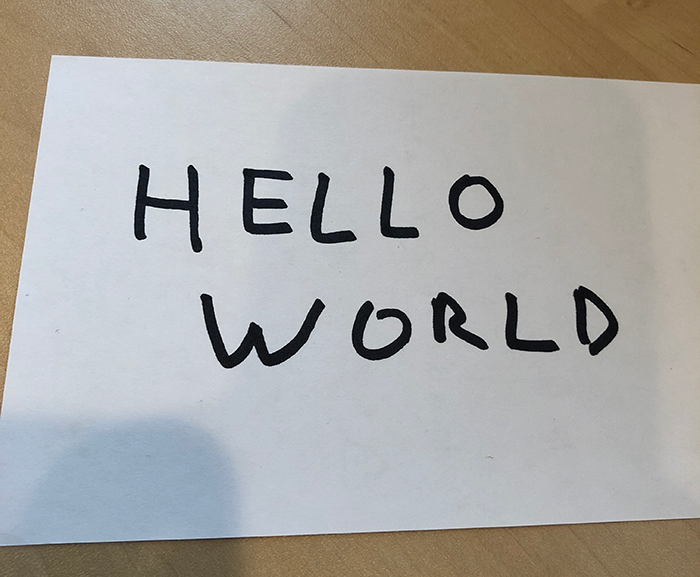

In [17]:
img = cv2.imread('/content/drive/MyDrive/ocr/hello_world.png')
cv2_imshow(img)

#1 -  Gray Scale

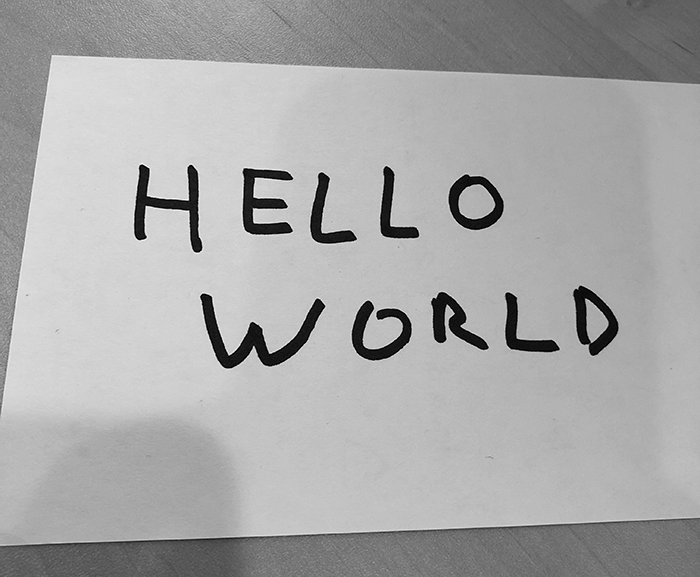

In [18]:
gray=get_grayscale(img)
cv2_imshow(gray)

# 2- Denoising

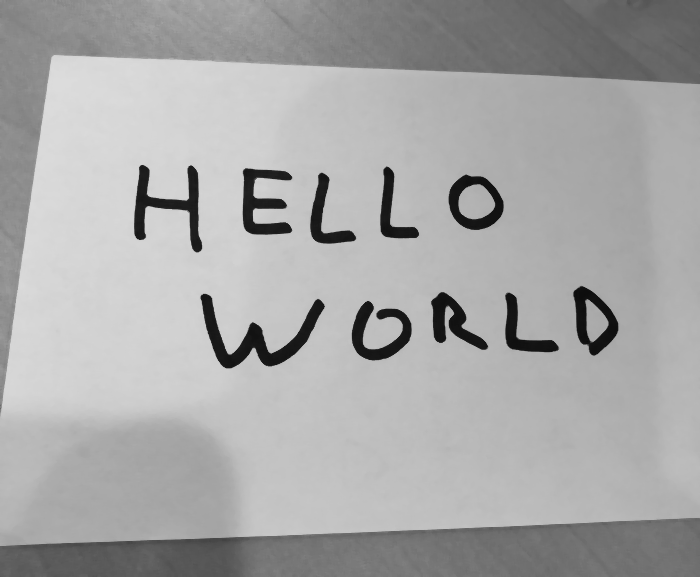

In [19]:
denoised=remove_noise(gray)
cv2_imshow(denoised)

# 2- Binarization

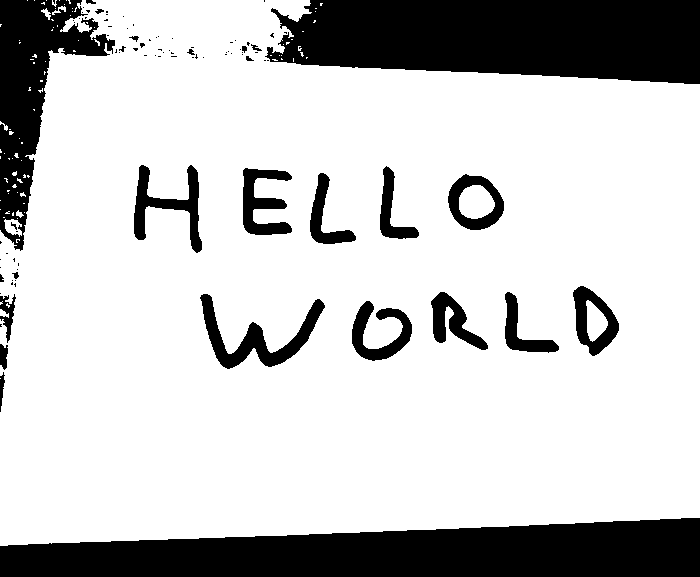

In [20]:
thresh = thresholding(denoised)
cv2_imshow(thresh)

# 3- De-Skewing

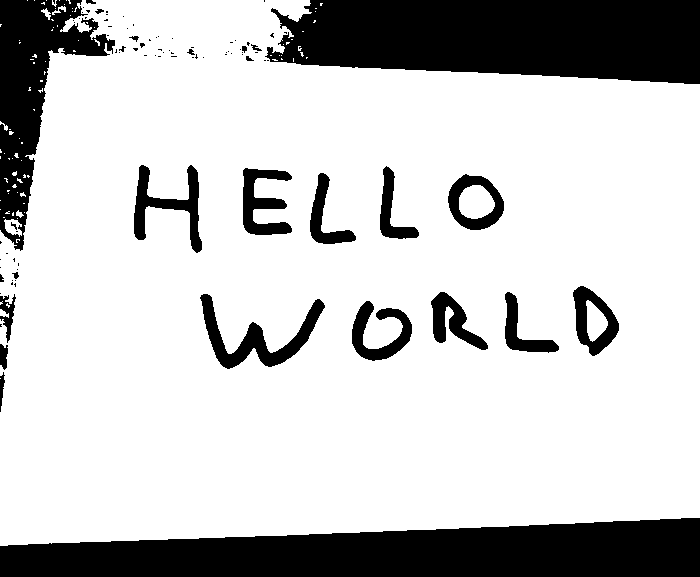

In [21]:
deskewed=deskew(thresh)
cv2_imshow(deskewed)

In [22]:

edged = cv2.Canny(deskewed, 30, 150)
cnts = cv2.findContours(edged.copy(), cv2.RETR_EXTERNAL,cv2.CHAIN_APPROX_SIMPLE)
cnts = imutils.grab_contours(cnts)
cnts = sort_contours(cnts, method="left-to-right")[0]


In [25]:

# initialize the list of contour bounding boxes and associated
# characters that we'll be OCR'ing
chars = []

# loop over the contours
for c in cnts:
	# compute the bounding box of the contour
	(x, y, w, h) = cv2.boundingRect(c)

	# filter out bounding boxes, ensuring they are neither too small
	# nor too large
	if (w >= 5 and w <= 150) and (h >= 15 and h <= 120):
		# extract the character and threshold it to make the character
		# appear as *white* (foreground) on a *black* background, then
		# grab the width and height of the thresholded image
		roi = gray[y:y + h, x:x + w]
		thresh = cv2.threshold(roi, 0, 255,cv2.THRESH_BINARY_INV | cv2.THRESH_OTSU)[1]
		(tH, tW) = thresh.shape

		# if the width is greater than the height, resize along the
		# width dimension
		if tW > tH:
			thresh = imutils.resize(thresh, width=32)

		# otherwise, resize along the height
		else:
			thresh = imutils.resize(thresh, height=32)

		# re-grab the image dimensions (now that its been resized)
		# and then determine how much we need to pad the width and
		# height such that our image will be 32x32
		(tH, tW) = thresh.shape
		dX = int(max(0, 32 - tW) / 2.0)
		dY = int(max(0, 32 - tH) / 2.0)

		# pad the image and force 32x32 dimensions
		padded = cv2.copyMakeBorder(thresh, top=dY, bottom=dY,
			left=dX, right=dX, borderType=cv2.BORDER_CONSTANT,
			value=(0, 0, 0))
		padded = cv2.resize(padded, (32, 32))

		# prepare the padded image for classification via our
		# handwriting OCR model
		padded = padded.astype("float32") / 255.0
		padded = np.expand_dims(padded, axis=-1)

		# update our list of characters that will be OCR'd
		chars.append((padded, (x, y, w, h)))


1/1 [==============================] - 0s 110ms/step


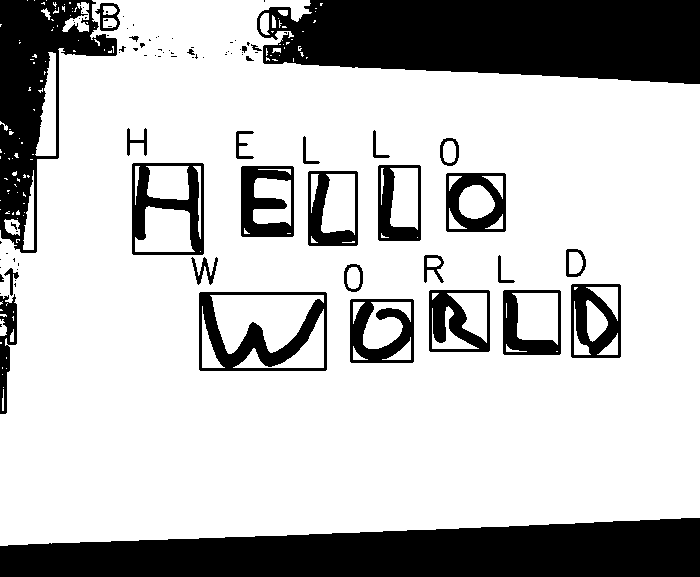

In [26]:

# extract the bounding box locations and padded characters
boxes = [b[1] for b in chars]
chars = np.array([c[0] for c in chars], dtype="float32")

# OCR the characters using our handwriting recognition model
preds = model.predict(chars)


# define the list of label names
labelNames = "0123456789"
labelNames += "ABCDEFGHIJKLMNOPQRSTUVWXYZ"
labelNames = [l for l in labelNames]

# loop over the predictions and bounding box locations together
for (pred, (x, y, w, h)) in zip(preds, boxes):
	# find the index of the label with the largest corresponding
	# probability, then extract the probability and label
	i = np.argmax(pred)
	prob = pred[i]
	label = labelNames[i]
	# draw the prediction on the image
	cv2.rectangle(deskewed, (x, y), (x + w, y + h), (0, 255, 0), 2)
	cv2.putText(deskewed, label, (x - 10, y - 10),cv2.FONT_HERSHEY_SIMPLEX, 1.2, (0, 255, 0), 2)
	cv2.waitKey(0)
# show the image
cv2_imshow(deskewed)

# EasyOCR

Prediction  using easy OCR

In [27]:
!pip install easyocr

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.9/2.9 MB 21.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 908.3/908.3 kB 53.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 146.0/146.0 kB 15.4 MB/s eta 0:00:00


In [28]:
# set the matplotlib backend so figures can be saved in the background
import matplotlib
# import the necessary
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import SGD
from sklearn.preprocessing import LabelBinarizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from tensorflow.keras.models import load_model
import cv2
from imutils.contours import sort_contours
from imutils import build_montages
import matplotlib.pyplot as plt
import numpy as np
from google.colab.patches import cv2_imshow


In [29]:

# import the necessary packages
from tensorflow.keras.models import load_model
from imutils.contours import sort_contours
import numpy as np
import argparse
import imutils
import cv2
from google.colab.patches import cv2_imshow

In [30]:
from easyocr import Reader

In [31]:
import cv2
import numpy as np
# get grayscale image
def get_grayscale(image):
    return cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

# noise removal
def remove_noise(image):
    return cv2.medianBlur(image,5)

#thresholding
def thresholding(image):
    return cv2.threshold(image, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)[1]

#adaptiveThresholding
def adadaptiveThresholding(image):
    return cv2.adaptiveThreshold(image,255,cv2.ADAPTIVE_THRESH_GAUSSIAN_C,\
            cv2.THRESH_BINARY,11,2)

#dilation
def dilate(image):
    kernel = np.ones((5,5),np.uint8)
    return cv2.dilate(image, kernel, iterations = 1)

#erosion
def erode(image):
    kernel = np.ones((5,5),np.uint8)
    return cv2.erode(image, kernel, iterations = 1)

#opening - erosion followed by dilation
def opening(image):
    kernel = np.ones((5,5),np.uint8)
    return cv2.morphologyEx(image, cv2.MORPH_OPEN, kernel)

#canny edge detection
def canny(image):
    return cv2.Canny(image, 100, 200)

#skew correction
def deskew(image):
    coords = np.column_stack(np.where(image > 0))
    angle = cv2.minAreaRect(coords)[-1]
    if angle < -45:
        angle = -(90 + angle)
    else:
        angle = -angle
    (h, w) = image.shape[:2]
    center = (w // 2, h // 2)
    M = cv2.getRotationMatrix2D(center, angle, 1.0)
    rotated = cv2.warpAffine(image, M, (w, h), flags=cv2.INTER_CUBIC, borderMode=cv2.BORDER_REPLICATE)
    return rotated

#cropping
def cropping(image):
    return image[200:510,200:2200]


#template matching
def match_template(image, template):
    return cv2.matchTemplate(image, template, cv2.TM_CCOEFF_NORMED)

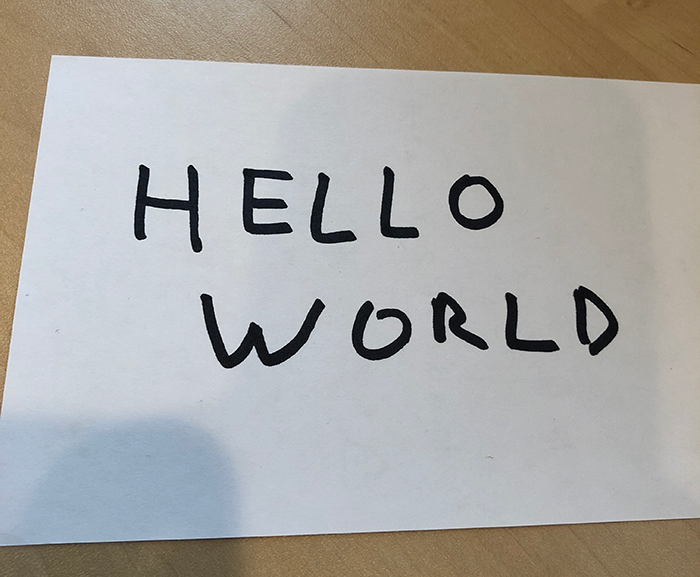

In [32]:
date_img = cv2.imread('/content/drive/MyDrive/ocr/hello_world.png')
cv2_imshow(date_img)

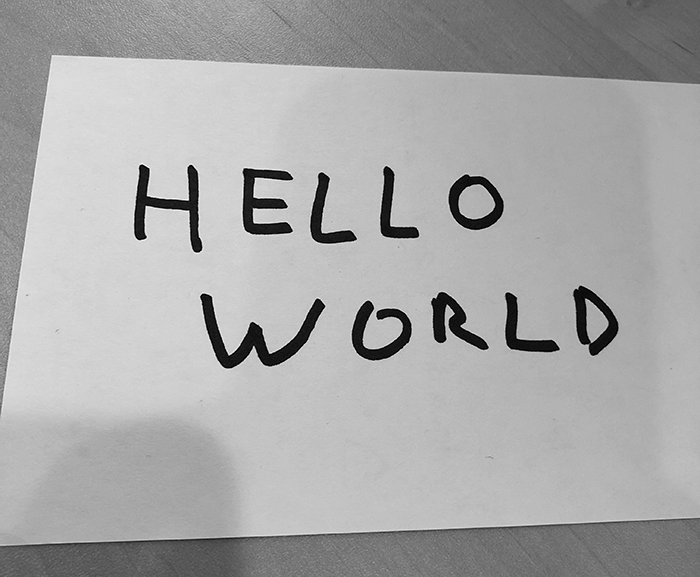

In [33]:
gray=get_grayscale(date_img)
cv2_imshow(gray)

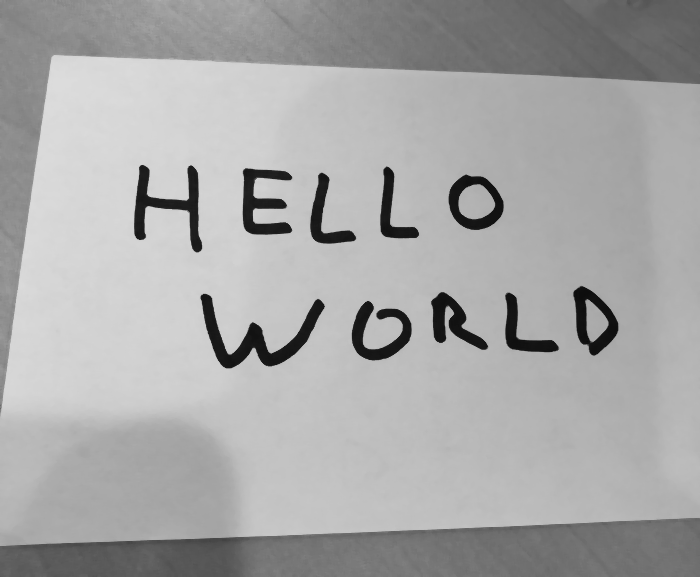

In [34]:
denoised=remove_noise(gray)
cv2_imshow(denoised)

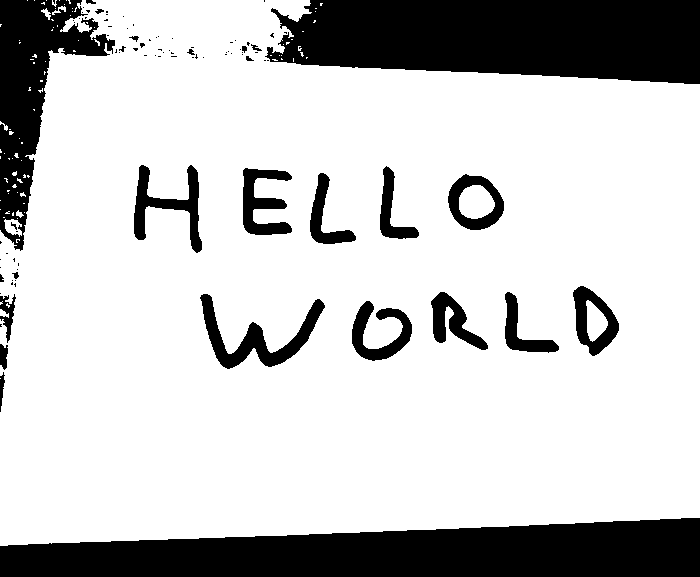

In [35]:
thresh = thresholding(denoised)
cv2_imshow(thresh)

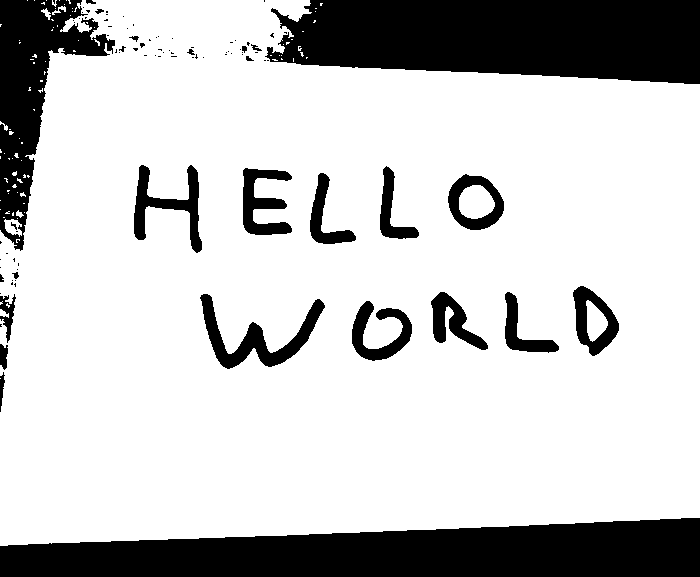

In [36]:
deskewed=deskew(thresh)
cv2_imshow(deskewed)

In [37]:

edged = cv2.Canny(deskewed, 30, 150)
cnts = cv2.findContours(edged.copy(), cv2.RETR_EXTERNAL,cv2.CHAIN_APPROX_SIMPLE)
cnts = imutils.grab_contours(cnts)
cnts = sort_contours(cnts, method="left-to-right")[0]

In [38]:
len(cnts)

229

In [39]:
cnts[0][0][0]

array([682, 517], dtype=int32)

In [40]:
for c in cnts:
  (x, y, w, h) = cv2.boundingRect(c)
  cv2.rectangle(date_img, (x,y), (x+w, y+h), (0,255,0),3)

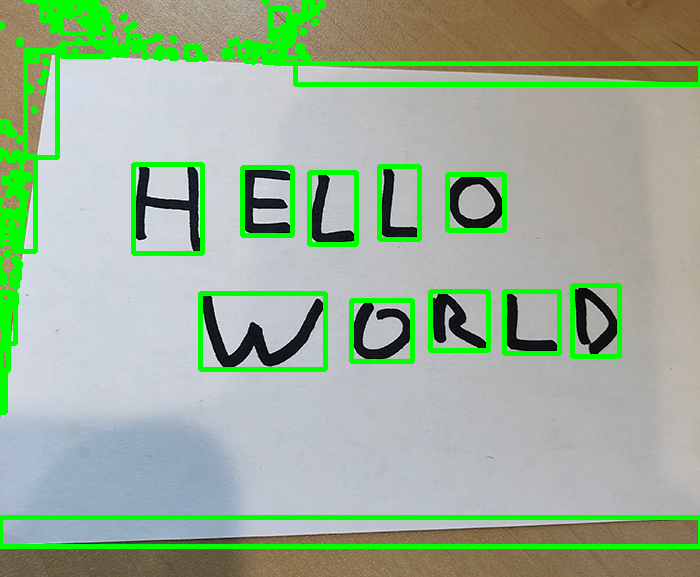

In [41]:
cv2_imshow(date_img)

In [42]:


chars = []

for c in cnts:
	(x, y, w, h) = cv2.boundingRect(c)
	cv2.rectangle(date_img, (x,y), (x+w, y+h), (0,255,0),3)
	if (w >= 5 and w <= 150) and (h >= 15 and h <= 120):
		#cv2.rectangle(date_img, (x,y), (x+w, y+h), (0,255,0),3)
		roi = gray[y:y + h, x:x + w]
		thresh = cv2.threshold(roi, 0, 255,cv2.THRESH_BINARY_INV | cv2.THRESH_OTSU)[1]
		(tH, tW) = thresh.shape

		if tW > tH:
			thresh = imutils.resize(thresh, width=32)
		else:
			thresh = imutils.resize(thresh, height=32)

		(tH, tW) = thresh.shape
		dX = int(max(0, 32 - tW) / 2.0)
		dY = int(max(0, 32 - tH) / 2.0)

		padded = cv2.copyMakeBorder(thresh, top=dY, bottom=dY,left=dX, right=dX, borderType=cv2.BORDER_CONSTANT,value=(0, 0, 0))
		padded = cv2.resize(padded, (32, 32))

		padded = padded.astype("float32") / 255.0
		padded = np.expand_dims(padded, axis=-1)

		chars.append((padded, (x, y, w, h)))


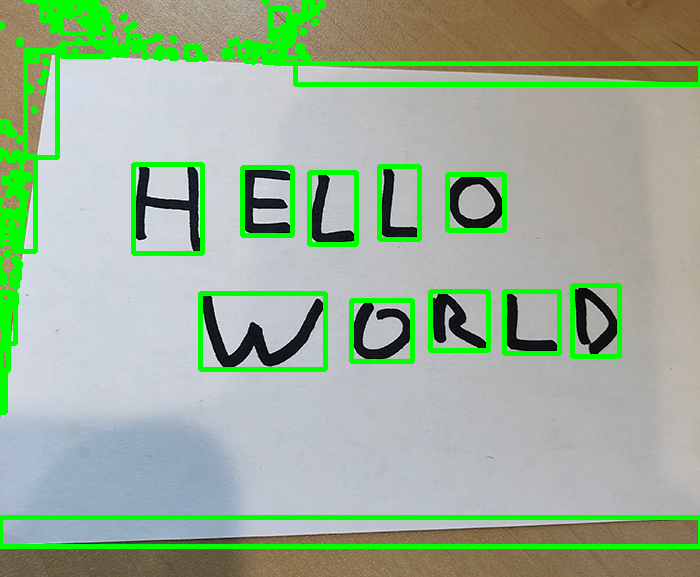

In [43]:
cv2_imshow(date_img)

1/1 [==============================] - 0s 88ms/step


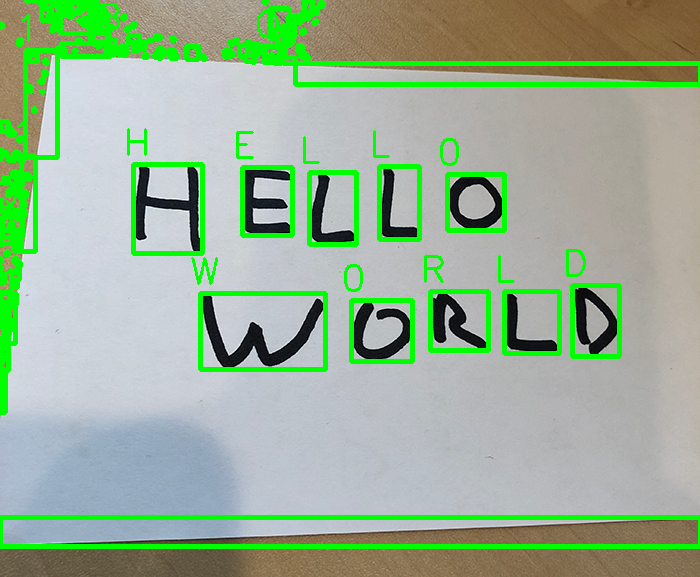

In [44]:
boxes = [b[1] for b in chars]
chars = np.array([c[0] for c in chars], dtype="float32")

preds = model.predict(chars)

#print(preds)
# define the list of label names
labelNames = "0123456789"
labelNames += "ABCDEFGHIJKLMNOPQRSTUVWXYZ"
labelNames = [l for l in labelNames]

# loop over the predictions and bounding box locations together
for (pred, (x, y, w, h)) in zip(preds, boxes):

	i = np.argmax(pred)
	prob = pred[i]
	label = labelNames[i]
	# draw the prediction on the image
	#print("[INFO] {} - {:.2f}%".format(label, prob * 100))
	cv2.rectangle(date_img, (x, y), (x + w, y + h), (0, 255, 0), 2)
	cv2.putText(date_img, label, (x - 10, y - 10),cv2.FONT_HERSHEY_SIMPLEX, 1.2, (0, 255, 0), 2)
	# show the image
	#cv2_imshow(date_img)
	cv2.waitKey(0)
cv2_imshow(date_img)